### Libraries and data load

In [ ]:
# TODO: zaczynać wykresy słupkowe od 0

In [2]:
# library import
import pandas as pd
import numpy as np
import math as m

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.ticker import FuncFormatter, PercentFormatter
from pandas.api.types import is_numeric_dtype
from typing import Union, Literal

In [3]:
# loading data
df_freq = pd.read_csv(r"data\cleaned_data.csv")
df_freq

,ClaimNb,Exposure,VehAge,DrivAge,BonusMalus,Density,Area,VehPower,VehBrand,VehGas,Region,ClaimFrequency
0,1.0,0.10000,0.0,55.0,50.0,1217.0,D,5,B12,Regular,R82,1.000000
1,1.0,0.77000,0.0,55.0,50.0,1217.0,D,5,B12,Regular,R82,1.298701
2,1.0,0.75000,2.0,52.0,50.0,54.0,B,6,B12,Diesel,R22,1.333333
3,1.0,0.09000,0.0,46.0,50.0,76.0,B,7,B12,Diesel,R72,1.000000
4,1.0,0.84000,0.0,46.0,50.0,76.0,B,7,B12,Diesel,R72,1.190476
...,...,...,...,...,...,...,...,...,...,...,...,...
678008,0.0,0.00274,0.0,54.0,50.0,3317.0,E,4,B12,Regular,R93,0.000000
678009,0.0,0.00274,0.0,41.0,95.0,9850.0,E,4,B12,Regular,R11,0.000000
678010,0.0,0.00274,2.0,45.0,50.0,1323.0,D,6,B12,Diesel,R82,0.000000
678011,0.0,0.00274,0.0,60.0,50.0,95.0,B,4,B12,Regular,R26,0.000000


### Exploratory data analysis

In [4]:
# quick look on data description
df_freq.describe()

,ClaimNb,Exposure,VehAge,DrivAge,BonusMalus,Density,VehPower,ClaimFrequency
count,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000
mean,0.053192,0.528750,6.956447,45.443271,59.761502,1792.422405,6.454631,0.076328
std,0.238202,0.364442,5.398474,14.038012,15.636658,3958.646564,2.050906,0.383065
min,0.000000,0.002732,0.000000,18.000000,50.000000,1.000000,4.000000,0.000000
25%,0.000000,0.180000,2.000000,34.000000,50.000000,92.000000,5.000000,0.000000
50%,0.000000,0.490000,6.000000,44.000000,50.000000,393.000000,6.000000,0.000000
75%,0.000000,0.990000,11.000000,55.000000,64.000000,1658.000000,7.000000,0.000000
max,5.000000,2.010000,25.000000,87.000000,230.000000,27000.000000,15.000000,15.151515


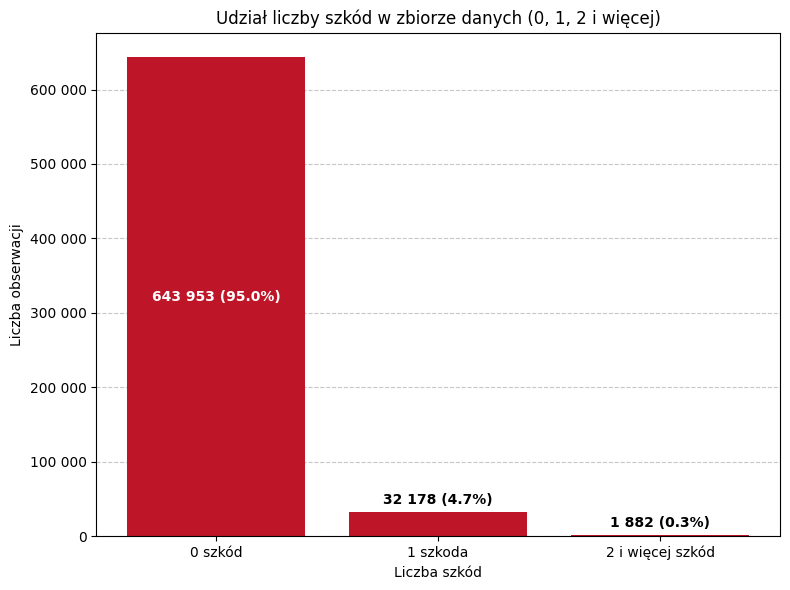

In [27]:
# Distribution of claim numbers (vertical bar chart, aggregated 0/1/2+)
sns.set_palette("pastel")
claim_agg = df_freq["ClaimNb"].copy()
claim_agg = claim_agg.apply(lambda x: x if x < 2 else 2)
claim_agg = claim_agg.value_counts().sort_index()
labels = ['0 szkód', '1 szkoda', '2 i więcej szkód']
counts = [claim_agg.get(0, 0), claim_agg.get(1, 0), claim_agg.get(2, 0)]

# # Reverse order so 0 is on left (to match model_analysis_plot style)
# labels = labels[::-1]
# counts = counts[::-1]

fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(labels, counts, color='#BF1528', zorder=2)

formatter = FuncFormatter(lambda x, pos: '{:,.0f}'.format(x).replace(',', ' '))
ax.yaxis.set_major_formatter(formatter)
ax.set_xlabel('Liczba szkód')
ax.set_ylabel('Liczba obserwacji')
ax.set_title('Udział liczby szkód w zbiorze danych (0, 1, 2 i więcej)')
ax.grid(True, axis='y', linestyle='--', alpha=0.7, zorder=1)

total = sum(counts)
for bar, count in zip(bars, counts):
    height = bar.get_height()
    count_str = f'{count:,}'.replace(',', ' ')
    label = f'{count_str} ({count/total*100:.1f}%)'
    if height > total * 0.08:
        ax.text(bar.get_x() + bar.get_width()/2, height/2, label, ha='center', va='center', color='white', fontweight='bold')
    else:
        ax.text(bar.get_x() + bar.get_width()/2, height + total*0.01, label, ha='center', va='bottom', color='black', fontweight='bold')

plt.tight_layout()
plt.show()

Jak widać, tylko około 5% obserwacji miało wartość numeru roszczenia inną niż 0. Jest to ważna cecha zbioru danych, którą należy uwzględnić podczas szkolenia modelu.

Tylko około 5% obserwacji zawiera co najmniej jedno roszczenie. Ta nierównowaga klas powoduje kilka wyzwań, w tym stronnicze modele czy trudności w wyborze modelu. Co więcej, ta nierównowaga spowoduje stronniczość eksploracyjnej analizy danych, więc w niektórych przypadkach ograniczę zakres danych, aby uwzględnić tylko obserwacje o częstotliwości roszczeń większej niż zero.

In [ ]:
def model_analysis_plot(data: pd.DataFrame,
                        x: str, 
                        y: str, 
                        w: str = None, 
                        y_pred: np.array = None, 
                        y_pred_prev: np.array = None, 
                        x_min: float = 0, 
                        x_max: float = None, 
                        n_bins: int = 10, 
                        bin_size: float = None, 
                        show: bool = True, 
                        x_max_quantile: float = None, 
                        max_categories: int = None, 
                        categories_threshold: Union[int, float] = None, 
                        categories_list: list[str] = None, 
                        format_x: bool = True, 
                        model_kind: Literal['poisson', 'gamma', 'binomial'] = 'poisson', 
                        dispersion: float = 1.0, 
                        dispersion_prev: float = 1.0, 
                        sort_categories: bool = False,
                        title: str =''):
    """
    Plots a dual-axis chart comparing actual vs. predicted values across different segments (bins or categories) of feature 'x'.
    It includes weighted averages and confidence intervals based on the specified model distribution.
    """
    
    # --- 1. Data Preparation ---
    x_label = x
    y_label = y

    # Extract columns as Series for easier manipulation
    x = data[x].squeeze()
    y = data[y].squeeze()  

    # Handle Weights (Exposure)
    # If a weight column 'w' is provided, use it. Otherwise, set all weights to 1.
    if w is not None:
        w_label = w
        w = data[w].squeeze()
    else:
        w = pd.Series(np.ones(len(data)))

    # --- 2. Feature Type Detection (Categorical vs Numerical) ---
    # Heuristic: If x is numeric but only has 2 unique values (0 and 1), treat it as categorical.
    if is_numeric_dtype(x.dtype):
        x_unique = x.unique()
        if len(x_unique) == 2 and 0 in x_unique and 1 in x_unique:
            x = x.astype('str').astype('category')

    # Check if the feature is effectively categorical
    is_categorical = x.dtype == 'category' or x.dtype == 'object'

    # --- 3. Processing Categorical Data ---
    if is_categorical:
        cats_means = {} # Dictionary to store results for each category
        
        # Determine which categories to plot
        if categories_list is None:
            categories_list = list(x.unique()) # Default: use all categories
            
            # Logic to filter categories based on frequency thresholds
            if categories_threshold is not None:
                if type(categories_threshold) == int:
                    # Keep categories with absolute count >= threshold
                    categories_counts = x.value_counts()
                if type(categories_threshold) == float:
                    # Keep categories with relative frequency >= threshold
                    categories_counts = x.value_counts(normalize=True)
                
                categories_list = list(categories_counts[categories_counts >= categories_threshold].index)
            
            elif max_categories is not None:
                # Keep top N most frequent categories
                categories_counts = x.value_counts()
                categories_list = list(categories_counts.index)
            
            # Apply the limit if max_categories is set
            if max_categories is not None:
                categories_list = list(categories_list[:max_categories])
        
        # Only keep categories with at least some data (nonzero count)
        categories_counts = x.value_counts()
        categories_list = [cat for cat in categories_list if categories_counts.get(cat, 0) > 0]
        
        # Loop through each selected category to calculate metrics
        for c in categories_list:
            mask_cat = x == c # Boolean mask for the current category
            cat_y = y[mask_cat]
            cat_w = w[mask_cat]
            
            # Calculate Weighted Average of Actuals (Target)
            # Formula: Sum(y * w) / Sum(w)
            if sum(cat_w) > 0:
                y_result = np.average(cat_y, weights=cat_w)
                cat_count = sum(cat_w) # Total exposure/weight for this category
                cats_means[c] = {
                    'count': cat_count,
                    'y': y_result}
                    
            # Calculate metrics for the Current Model Prediction
            if y_pred is not None:
                cat_y_pred = y_pred[mask_cat]
                y_pred_result = np.average(cat_y_pred, weights=cat_w)
                # Calculate variance for Confidence Interval (logic depends on get_variance function)
                # q_var = get_variance(y_pred_result, model_kind, dispersion) 
                # Assuming simple Poisson variance for explanation: Var = Mean
                q_var = y_pred_result 
                
                cats_means[c].update({'y_pred': y_pred_result, 'var': q_var})
            
            # Calculate metrics for the Previous Model Prediction (if provided)
            if y_pred_prev is not None:
                cat_y_pred_prev = y_pred_prev[mask_cat]
                y_pred_prev_result = np.average(cat_y_pred_prev, weights=cat_w)
                # q_var_prev = get_variance(y_pred_prev_result, model_kind, dispersion)                 
                q_var_prev = y_pred_prev_result
                
                cats_means[c].update({'y_pred_prev': y_pred_prev_result, 'var_prev': q_var_prev})
    # --- 4. Processing Numerical Data (Binning) ---
    else:  
        # Determine X-axis limits
        if x_min is None:
            x_min = x.min()
        if x_max is None:
            # Option to cut off outliers using a quantile (e.g., 0.99)
            if x_max_quantile is not None:
                assert x_max_quantile < 1 and x_max_quantile > 0
                x_max = x.quantile(x_max_quantile)
            else:
                x_max = x.max()
        
        # Determine bin configuration
        if bin_size is None:
            # Calculate bin size based on desired number of bins
            bin_size = (x_max - x_min) / n_bins
        else:
            # Calculate number of bins based on desired bin size
            n_bins = int((x_max - x_min) / bin_size)
        
        # Create histogram bins
        bin_counts, bin_edges = np.histogram(x, bins=n_bins, range=(x_min, x_max))
        ranges_means = {}
        
        prev_b = bin_edges[0]
        
        # Loop through bins to calculate metrics
        for i, b in enumerate(bin_edges):
            if i > 0:
                # Define boolean mask for the current bin range
                if i + 1 == len(bin_edges):
                    mask_bin = (x >= prev_b) & (x <= b) # Include right edge for last bin
                else:
                    mask_bin = (x >= prev_b) & (x < b)
                    
                bin_y = y[mask_bin]
                bin_w = w[mask_bin]
                
                # Calculate weighted averages if the bin is not empty
                if len(bin_w) > 0 and sum(bin_w) > 0:
                    y_result = np.average(bin_y, weights=bin_w)
                    bin_center = np.round(np.mean([prev_b, b]),1) # X-coordinate for plotting
                    ranges_means[bin_center] = {'y': y_result, 'count': sum(bin_w)}
                    
                    # Current Model Stats
                    if y_pred is not None:
                        bin_y_pred = y_pred[mask_bin]
                        y_pred_result = np.average(bin_y_pred, weights=bin_w)
                        # q_var = get_variance(y_pred_result, model_kind, dispersion) 
                        q_var = y_pred_result # Placeholder for missing function
                        ranges_means[bin_center].update({'y_pred': y_pred_result, 'var': q_var})
                    
                    # Previous Model Stats
                    if y_pred_prev is not None:
                        bin_y_pred_prev = y_pred_prev[mask_bin]
                        y_pred_prev_result = np.average(bin_y_pred_prev, weights=bin_w)
                        ranges_means[bin_center].update({'y_pred_prev': y_pred_prev_result})
                        # q_var_prev = get_variance(y_pred_prev_result, model_kind, dispersion)                 
                        q_var_prev = y_pred_prev_result # Placeholder
                        ranges_means[bin_center].update({'y_pred_prev': y_pred_prev_result, 'var_prev': q_var_prev})                       
            prev_b = b
    # --- 5. Plotting Setup ---
    # Create formatters for nice axis labels (e.g., thousands separator)
    formatter = FuncFormatter(lambda x, pos: '{:,.1f}'.format(x).replace(',', ' '))
    
    if model_kind in ['poisson', 'binomial']:
        freq_formatter = PercentFormatter(xmax=1.0, decimals=1) # e.g., 10.5%
    
    fig, ax = plt.subplots(1,1, figsize=(10,6))
    ax_twin = ax.twinx() # Create a second Y-axis sharing the same X-axis
    
    # --- 6. Plotting Categorical Results ---
    if is_categorical:
        cats_means = dict(sorted(cats_means.items(), key=lambda item: item[1]['count'], reverse=True))
        if sort_categories:
            cats_means = dict(sorted(cats_means.items()))
        
        # Only plot categories with at least some data (nonzero count)
        plot_keys = [k for k, v in cats_means.items() if v['count'] > 0]
        
        # Plot Exposure/Count as Bars on the primary (Left) Axis
        ax.bar(plot_keys, [cats_means[k]['count'] for k in plot_keys], color='#BF1528')
        
        # Plot Actuals and Predictions as Lines on the secondary (Right) Axis
        ax_twin.plot(plot_keys, [cats_means[k]['y'] for k in plot_keys], color='orange', marker='s', linestyle='none', label='Wartość rzeczywista')
        
        if y_pred_prev is not None:
            ax_twin.plot(plot_keys, [cats_means[k]['y_pred_prev'] for k in plot_keys], color='#D90166', marker='o', linestyle='none', label='Wartość przewidywana (poprzedni model)')
        
        if y_pred is not None:
            ax_twin.plot(plot_keys, [cats_means[k]['y_pred'] for k in plot_keys], color='black', marker='o', linestyle='none', label='Wartość przewidywana (nowy model)' if y_pred_prev is not None else 'Predicted Value')
        
        # Configure Axis Locations
        ax.set_xlabel(x_label)
        ax.yaxis.set_major_formatter(formatter)
        
        # Swap axis sides: Bar plot scale on Right, Line plot scale on Left
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position("right")
        ax_twin.yaxis.tick_left()
        ax_twin.yaxis.set_label_position("left")
        
        ax.grid(True, alpha=0.5)
        ax_twin.grid(False) # Turn off grid for secondary axis to avoid clutter
        
        # Start y-axis from 0 for both axes
        ax.set_ylim(bottom=0)
        ax_twin.set_ylim(bottom=0)
        
        # Calculate Confidence Intervals (95% CI)
        # Formula: 1.96 * sqrt(Variance / Count)
        if y_pred_prev is not None:
            CI = [1.96 * (np.sqrt(cats_means[k]['var']) / np.sqrt(cats_means[k]['count'])) for k in plot_keys]
        
        if y_pred_prev is not None:
            CI_prev = [1.96 * (np.sqrt(cats_means[k]['var_prev']) / np.sqrt(cats_means[k]['count'])) for k in plot_keys]
        
        # Plot Shaded Area for Confidence Interval
        if y_pred is not None:
            ax_twin.fill_between(plot_keys, 
                             [np.maximum(cats_means[k]['y_pred'] - ci, 0) for k, ci in zip(plot_keys, CI)], 
                             [cats_means[k]['y_pred'] + ci for k, ci in zip(plot_keys, CI)], 
                             color='#575756', alpha=.6)
    # --- 7. Plotting Numerical Results (Histogram style) ---
    else:     
        # Only plot bins with at least some data (nonzero count)
        plot_keys = [k for k, v in ranges_means.items() if v['count'] > 0]
        
        # Plot Histogram of Exposure on primary axis
        ax.bar(plot_keys, [ranges_means[k]['count'] for k in plot_keys], color='#BF1528', width=(bin_edges[1]-bin_edges[0])*0.9)
        
        # Plot Lines on secondary axis
        ax_twin.plot(plot_keys, [ranges_means[k]['y'] for k in plot_keys], color='orange', marker='s', label='Actual Value')
        
        if y_pred_prev is not None:
            ax_twin.plot(plot_keys, [ranges_means[k]['y_pred_prev'] for k in plot_keys], color='#D90166', marker='o', label='Predicted (Prev Model)')
        
        if y_pred is not None:  
            ax_twin.plot(plot_keys, [ranges_means[k]['y_pred'] for k in plot_keys], color='black', marker='o', label='Predicted (New Model)' if y_pred_prev is not None else 'Predicted Value')
        
        ax.set_xlabel(x_label)
        
        if format_x == True:
            ax.xaxis.set_major_formatter(formatter)
        ax.yaxis.set_major_formatter(formatter)
        
        # Swap axis sides logic (same as categorical)
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position("right")
        ax_twin.yaxis.tick_left()
        ax_twin.yaxis.set_label_position("left")
        
        ax.grid(True, alpha=0.5)
        ax_twin.grid(False) # Turn off grid for secondary axis to avoid clutter
        
        # Start y-axis from 0 for both axes
        ax.set_ylim(bottom=0)
        ax_twin.set_ylim(bottom=0)
        
        # Calculate and Plot Confidence Intervals for Binned Data
        if y_pred is not None:
            CI = [1.96 * (np.sqrt(ranges_means[k]['var']) / np.sqrt(ranges_means[k]['count'])) for k in plot_keys]
        
        if y_pred is not None:
            ax_twin.fill_between(plot_keys, 
                             [np.maximum(ranges_means[k]['y_pred'] - ci, 0) for k, ci in zip(plot_keys, CI)], 
                             [ranges_means[k]['y_pred'] + ci for k, ci in zip(plot_keys, CI)], 
                             color='#575756', alpha=.6)
    # --- 8. Final Labels and Legend ---
    # Set axis labels based on the statistical model type
    if model_kind == 'poisson':
        ax.set_ylabel('Exposure')
        ax_twin.set_ylabel('Claim Frequency')
        ax_twin.yaxis.set_major_formatter(freq_formatter)
    elif model_kind == 'gamma':
        ax.set_ylabel('Number of Events')
        ax_twin.set_ylabel('Average Severity')
        ax_twin.yaxis.set_major_formatter(formatter)
    elif model_kind == 'binomial':
        ax.set_ylabel('Number of Offers')
        ax_twin.set_ylabel('Conversion Rate')
        ax_twin.yaxis.set_major_formatter(freq_formatter)        
    
    ax.set_title(title)
    plt.legend() # Shows legend for the lines
    
    if show:
        plt.show()

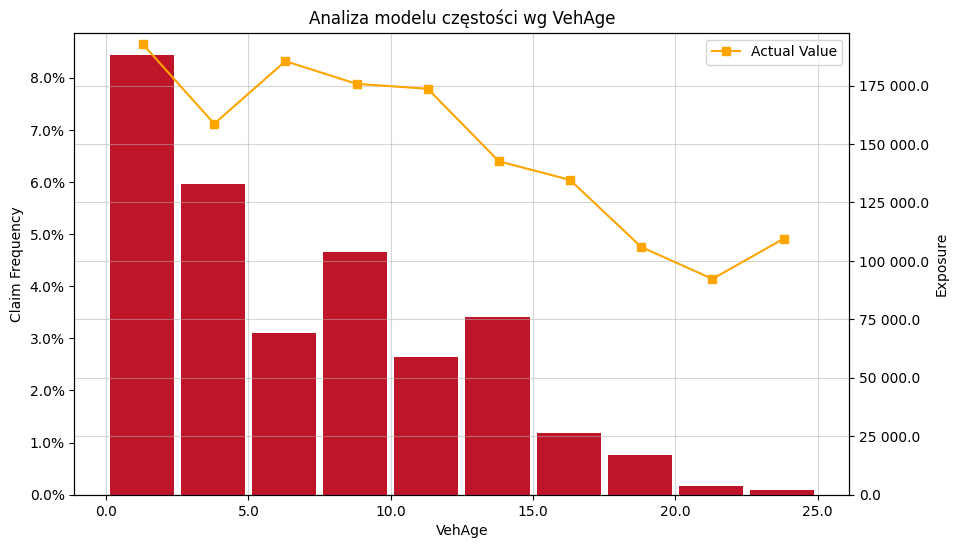

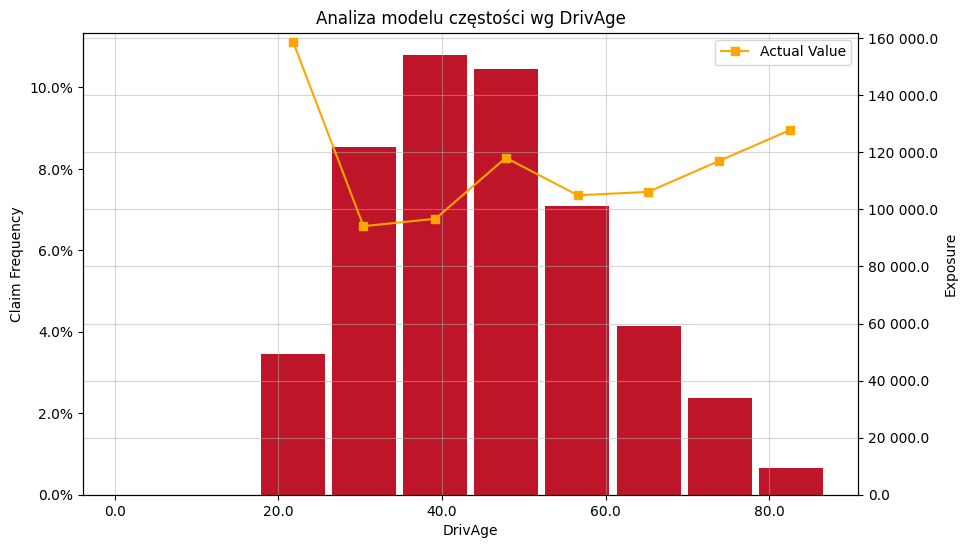

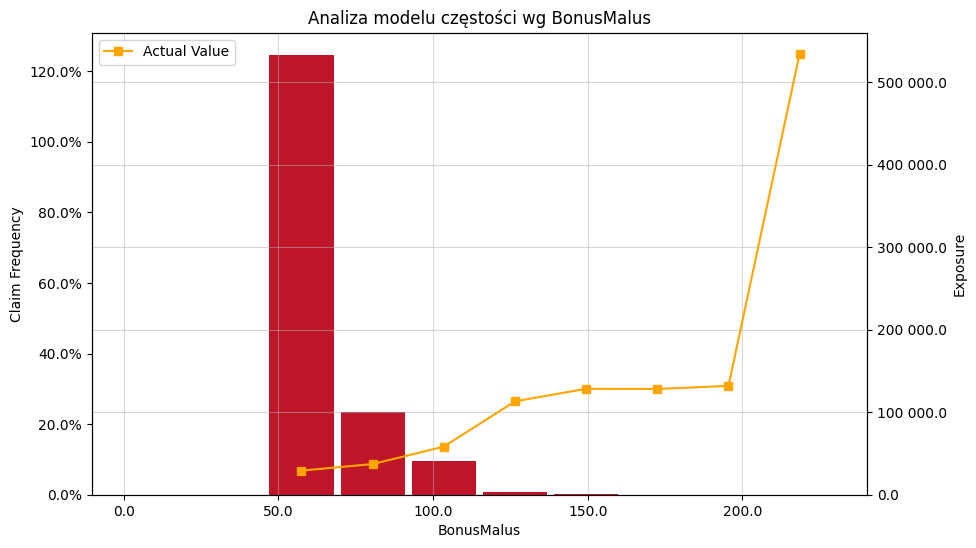

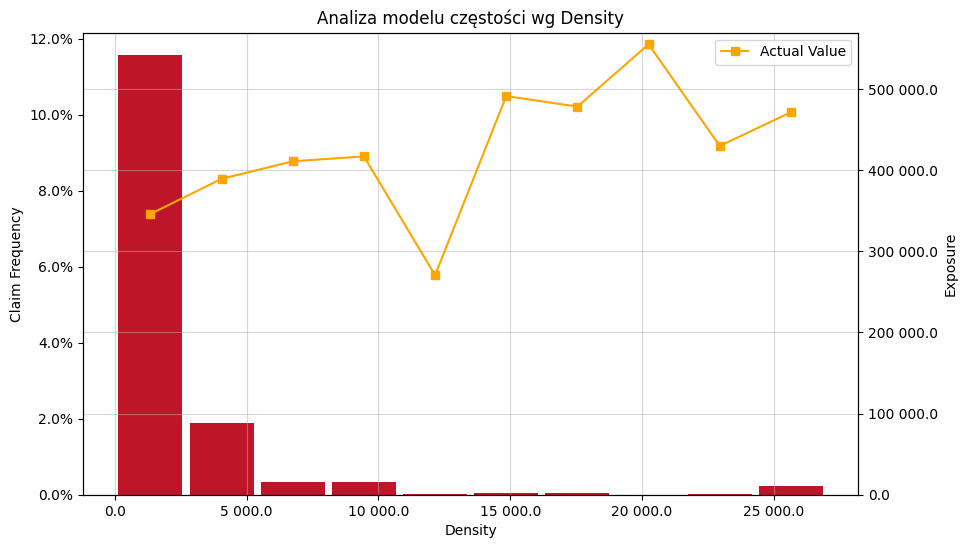

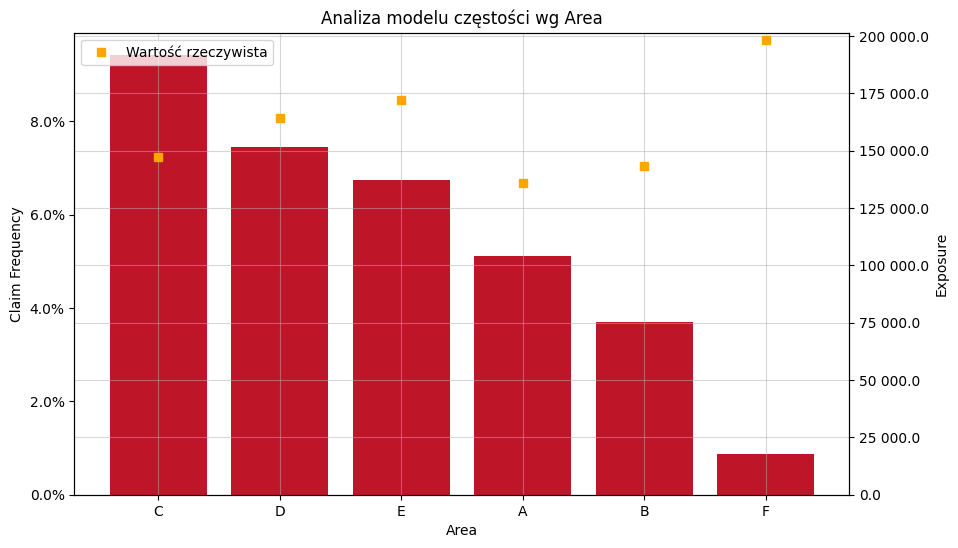

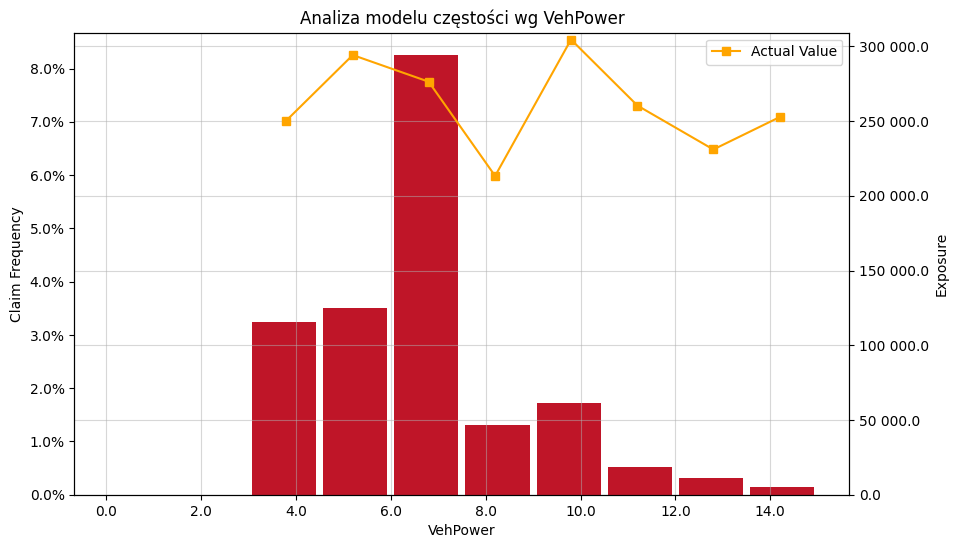

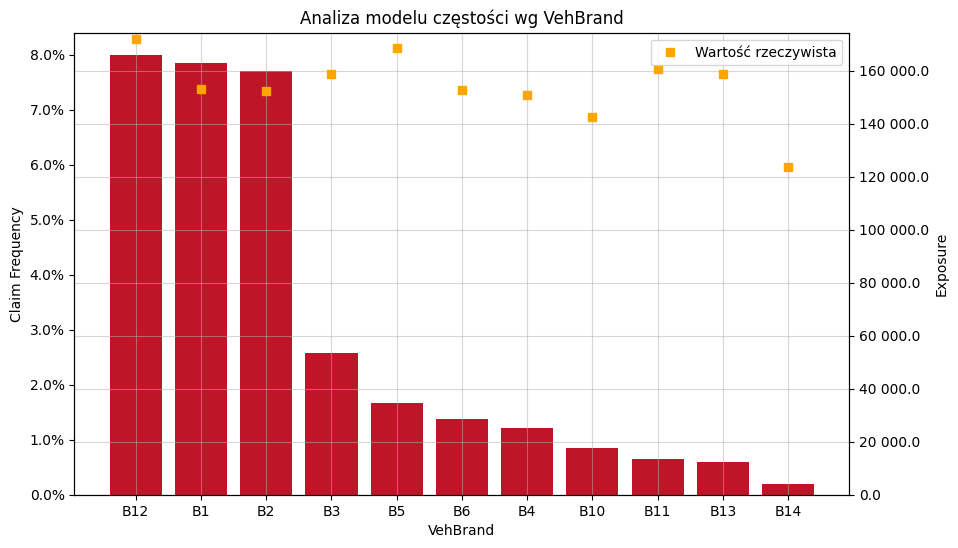

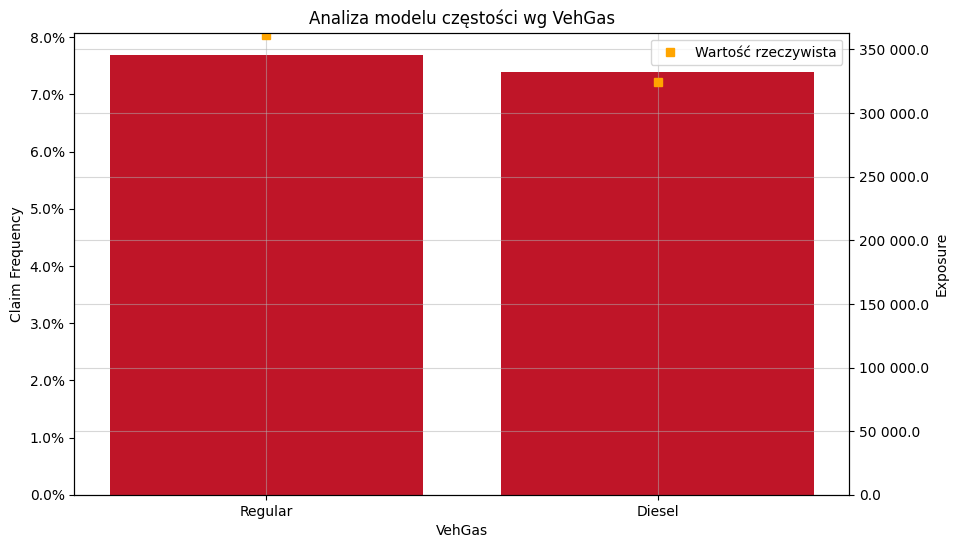

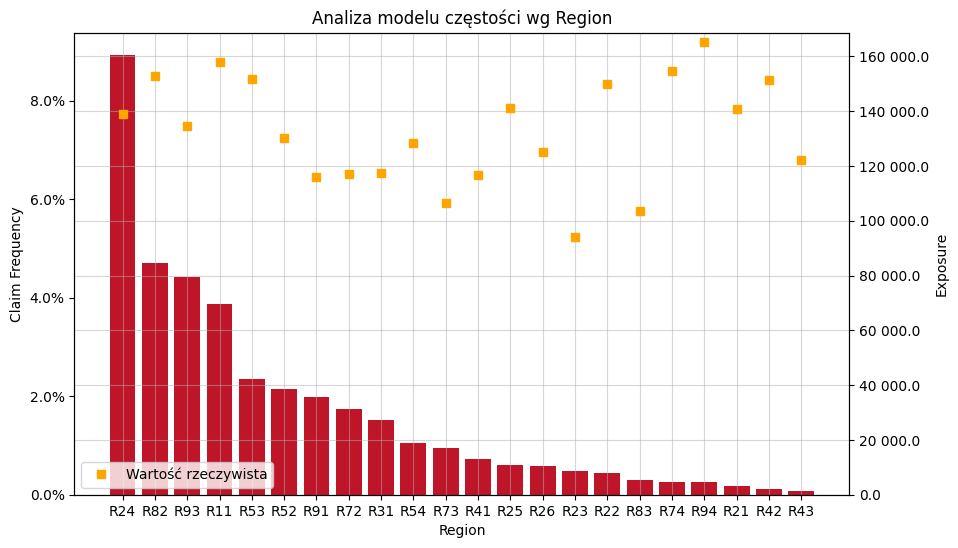

In [26]:
for col in df_freq.columns:
    if col not in ['ClaimFrequency', 'ClaimNb', 'Exposure']:
        model_analysis_plot(
            data=df_freq,
            x=col,
            y='ClaimFrequency',
            title=f'Analiza modelu częstości wg {col}'
        )

Analiza sugeruje, że VehPower wykazuje niewielką zmianę, przy czym pojazdy o niższej mocy są niedostatecznie reprezentowane w klasie pozytywnej. Rozkłady pośród obszarów są w większości stabilne, chociaż obszar "A" charakteryzuje się nieco wyższym wskaźnikiem roszczeń. VehBrand pozostaje spójny we wszystkich grupach, co wskazuje na brak silnej korelacji z roszczeniami. VehGas ujawnia, że pojazdy z silnikiem wysokoprężnym mają nieco niższą częstotliwość roszczeń, co może wynikać z różnych zachowań kierowców. Region wykazuje niewielkie różnice, przy czym niektóre obszary (np. R24, R91) mają nieco wyższy wskaźnik roszczeń.

Istnieją niewielkie różnice w rozkładzie zmiennej kategorycznej w obrębie każdej z rozpatrywanych kategorii, szczególnie w przypadku zmiennej „Region”.

In [63]:
print("Variance of claim frequency: ", np.var(df_freq["ClaimFrequency"]))
print("Mean of claim frequency: ", np.mean(df_freq["ClaimFrequency"]))

Variance of claim frequency:  0.14673276952835107
Mean of claim frequency:  0.07632303008365851


The claim frequency distribution is highly right-skewed, with a variance nearly double the mean. This overdispersion suggests that a Poisson distribution might not be sufficient, and a negative binomial distribution could be a better fit. I will test both shortly to determine the most appropriate modeling approach.

In [62]:
# function declaration for correlation matrix
def display_correlation_matrix(data: pd.DataFrame, figsize=(12,8)):
   '''
   visualizes the correlation matrix of numeric variables in a given DataFrame.

   data (pd.DataFrame): The input DataFrame containing the data.
   figsize (tuple, default=figsize): The size of the figure for the heatmap.
   '''
   cor_matrix = data.select_dtypes(include=[np.number]).corr()
   f, ax = plt.subplots(figsize=figsize)
   cmap = sns.diverging_palette(230, 20, as_cmap=True)

   sns.heatmap(cor_matrix, cmap=cmap, vmax=.3, center=0,
               square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")

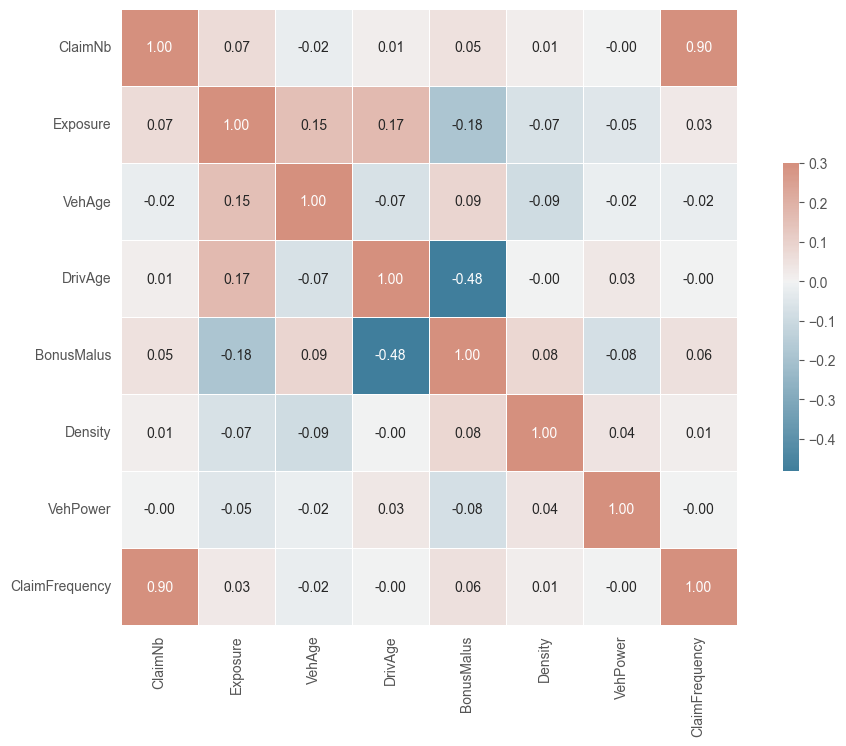

In [63]:
display_correlation_matrix(df_freq)

Claim frequency calculated as claim number divided by exposure period, obviously shows high linear correlation with claim number, a little unexpected is that corelation with exposure period is close to zero. Other features show weak correlations with claim frequency, indicating that no single variable strongly influences it. BonusMalus has a moderate negative correlation with DrivAge (-0.48), suggesting that younger drivers tend to have higher risk scores. Exposure has a mild positive correlation with DrivAge and VehAge, but overall, the relationships are weak.

This suggests that predicting claim frequency will likely require more complex modeling techniques beyond simple linear relationships.

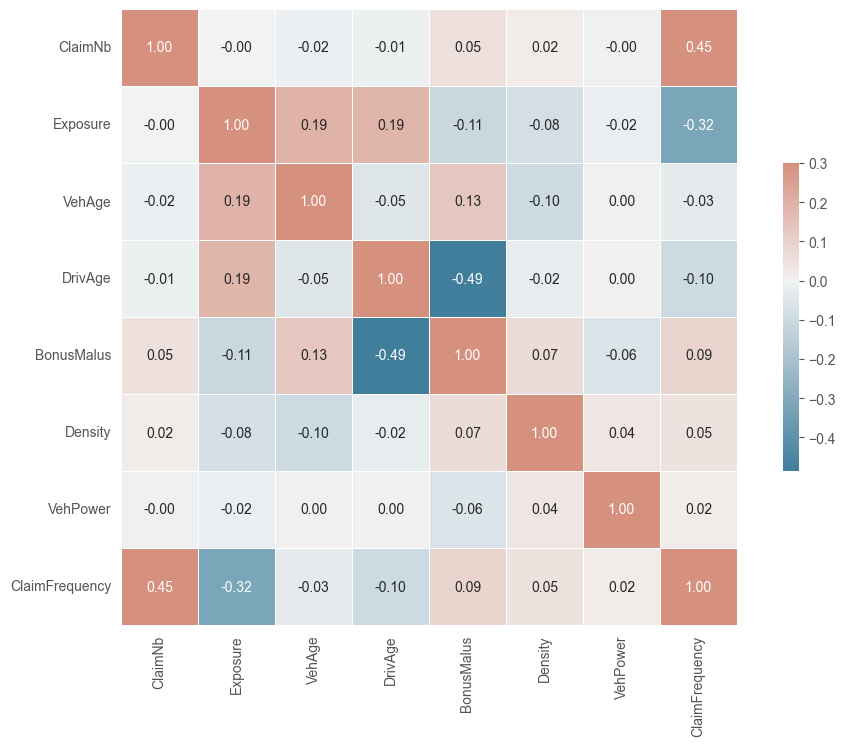

In [64]:
# correlation matrix for claim frequency above 0
df_freq_positive = df_freq[df_freq["ClaimFrequency"] > 0]
display_correlation_matrix(df_freq_positive)

Limiting data to only those with claim frequency above 0 doesn't have much impact. The correlation structure remains largely weak, reaffirming that no single variable has a strong linear impact on claim frequency. Compared to the full dataset, some differences emerge. The correlation between claim frequency and exposure is moderately negative, whereas it was close to zero before. The negative correlation between DrivAge and BonusMalus persists. A sligtly higher correlation is present between claim frequency and other features, but they are still weak.

For ClaimFrequency, a wider range of values is observed, especially in VehPower, VehAge, and DrivAge. While there is some spread, ClaimFrequency tends to be denser at lower values. In BonusMalus and Density, a noticeable concentration of lower-frequency claims appears at lower levels, but some higher values are also scattered. This indicates that while a few policyholders have high claim frequencies, they remain an exception.

For number of claims, most claims are concentrated at the lower values, suggesting that the majority of policyholders file only one claim. The scatter plots show that ClaimNb remains fairly stable across VehPower, VehAge, and DrivAge, without a strong visible trend, which aligns with the weak correlations seen in the matrix. There is some dispersion at higher values, but the density is much lower. BonusMalus and Density exhibit more dispersion, but claims are still concentrated at the lowest levels.

For exposure period values mainly concentrate between values of 0 and 1 with few exceptions, dosn't showing any strong patterns

Overall, the scatter plots support the correlation matrix's findings. There are no strong linear relationships, but some weak trends and concentration patterns emerge. The results suggest that factors like age, vehicle power, and density have a limited but noticeable impact on claim behavior.

The distribution of claim frequency across categorical values appears to vary between categories, primarily due to differences in the number of observations within each group. However, the average claim frequency remains relatively consistent across most categories, with the exception of the "region" feature, which shows a noticeable difference in distribution. Based on this, we can conclude that "region" may be one of the most useful features for model building.

Conclusions we can draw out of stripp plots of claim number are very similar to those showing claim frequency. Again "region" feature shows a noticeable difference in distribution, what is expected taking into consideration high corelation between claim number and claim frequency.

The dispersion of the exposure period is much more stable across classes. However, the average values show greater variation compared to claim number and claim frequency, not only in the "region" feature but also in others. On the other hand, the exposure period is a unique feature, as a claim during a shorter exposure period does not necessarily indicate a higher claim number over the entire policy duration. Additionally, differences in exposure periods may be influenced by the specifics of the French insurance market. A more in-depth analysis of this feature would require expert consultation to fully understand its implications.

In [ ]:
# 10 observations with highest claim frequency
top_10 = df_freq.nlargest(n=10, columns=["ClaimFrequency"])
top_10

,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,Area,VehBrand,VehGas,Region,ClaimFrequency
304474,5.0,0.33,4.0,12.0,52.0,50.0,824.0,D,B1,Regular,R91,15.151515
321238,5.0,0.33,4.0,12.0,52.0,50.0,824.0,D,B1,Regular,R91,15.151515
364427,4.0,0.27,5.0,9.0,23.0,90.0,6924.0,E,B3,Diesel,R11,14.814815
320754,5.0,0.41,4.0,12.0,52.0,50.0,824.0,D,B1,Regular,R91,12.195122
342114,3.0,0.27,5.0,7.0,40.0,51.0,403.0,C,B2,Diesel,R91,11.111111
522546,3.0,0.30,4.0,1.0,71.0,50.0,42.0,A,B12,Regular,R52,10.000000
214596,3.0,0.32,4.0,10.0,24.0,90.0,1955.0,D,B1,Regular,R94,9.375000
203389,3.0,0.36,4.0,2.0,57.0,50.0,1217.0,D,B4,Regular,R82,8.333333
424350,3.0,0.36,6.0,12.0,56.0,101.0,9307.0,E,B1,Diesel,R82,8.333333
461804,3.0,0.36,4.0,7.0,31.0,68.0,1974.0,D,B2,Diesel,R54,8.333333


In [ ]:
# 10 observations with lowest claim frequency
bottom_10 = df_freq.nsmallest(n=10, columns=["ClaimFrequency"])
bottom_10

,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,Area,VehBrand,VehGas,Region,ClaimFrequency
9385,0.0,0.005464,6.0,15.0,50.0,50.0,29.0,A,B2,Diesel,R24,0.0
9386,0.0,0.670000,6.0,15.0,50.0,50.0,29.0,A,B2,Diesel,R24,0.0
9387,0.0,0.890000,6.0,8.0,30.0,68.0,48.0,A,B1,Diesel,R53,0.0
9388,0.0,0.100000,6.0,8.0,30.0,57.0,48.0,A,B1,Diesel,R53,0.0
9389,0.0,0.200000,7.0,4.0,44.0,50.0,56.0,B,B14,Diesel,R24,0.0
9390,0.0,0.170000,6.0,10.0,49.0,95.0,26.0,A,B3,Diesel,R24,0.0
9391,0.0,1.000000,6.0,4.0,33.0,50.0,16.0,A,B1,Diesel,R24,0.0
9392,0.0,1.000000,7.0,8.0,31.0,50.0,17.0,A,B5,Diesel,R24,0.0
9393,0.0,1.000000,7.0,12.0,46.0,50.0,126.0,C,B5,Diesel,R24,0.0
9394,0.0,1.000000,6.0,11.0,55.0,50.0,67.0,B,B1,Diesel,R24,0.0


### Feature Engeneering

Based on real-world knowledge and the given exploratory data analysis, we can perform feature engineering to enhance model performance:
- creating a feature that captures the relationship between vehicle power and driver age, as younger drivers (who are generally considered more reckless) driving high-power vehicles may be more likely to cause claims. 
- applying a logarithmic transformation to numerical features could be beneficial. The scatter plots and correlation matrix indicate a nonlinear relationship between claim frequency and other variables, suggesting that a logarithmic transformation may help normalize distributions.
- creating a binary feature that indicates whether a claim has occurred (1 if a claim exists, 0 otherwise) can be useful for structuring the problem into two separate steps: classification and regression.

In [66]:
df_fe = df_freq

In [ ]:
# creating additional feature
df_fe["VehPowerDriverAge"] = df_fe["VehPower"]/df_fe["DrivAge"]

In [68]:
# transformying features
variables=["VehPower", "VehAge", "DrivAge", "BonusMalus", "Density"]
for i in variables:
    df_fe[f"Transform{i}"] = np.log(df_fe[i])

c:\Users\norbe\OneDrive\Desktop\Studia\Magisterskie\Analiza danych z Pythonem\PrzewidywanieCzestosciSzkod\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


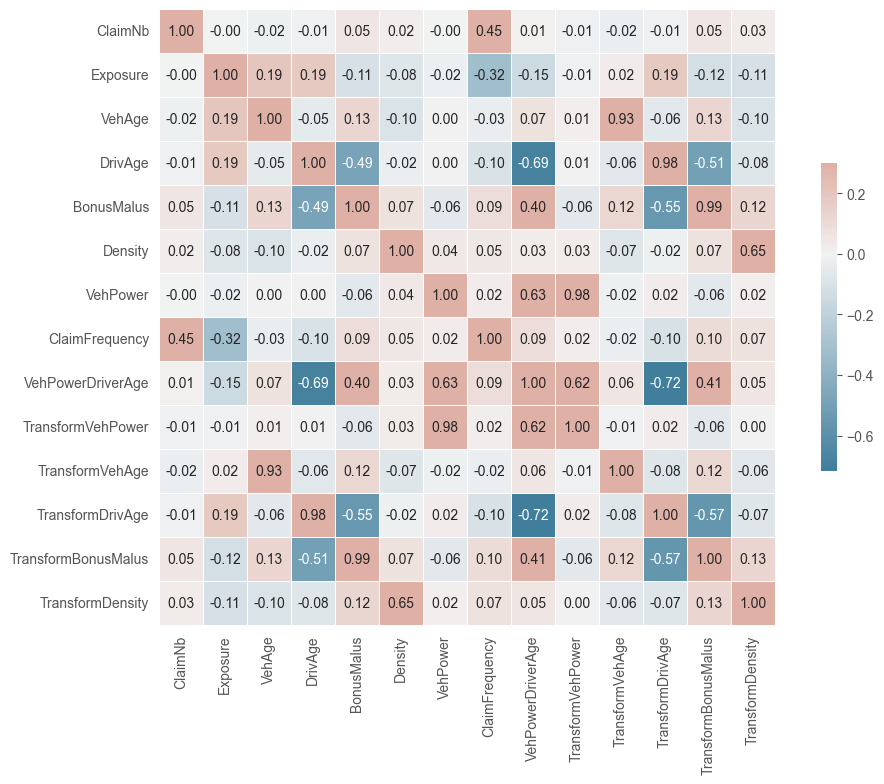

In [69]:
# corelation matrics including new features
display_correlation_matrix(df_fe[df_fe["ClaimFrequency"] > 0])

In [71]:
df_fe["VehPowerDriverAge"]

0         0.090909
1         0.090909
2         0.115385
3         0.152174
4         0.152174
            ...   
678008    0.074074
678009    0.097561
678010    0.133333
678011    0.066667
678012    0.241379
Name: VehPowerDriverAge, Length: 678013, dtype: float64

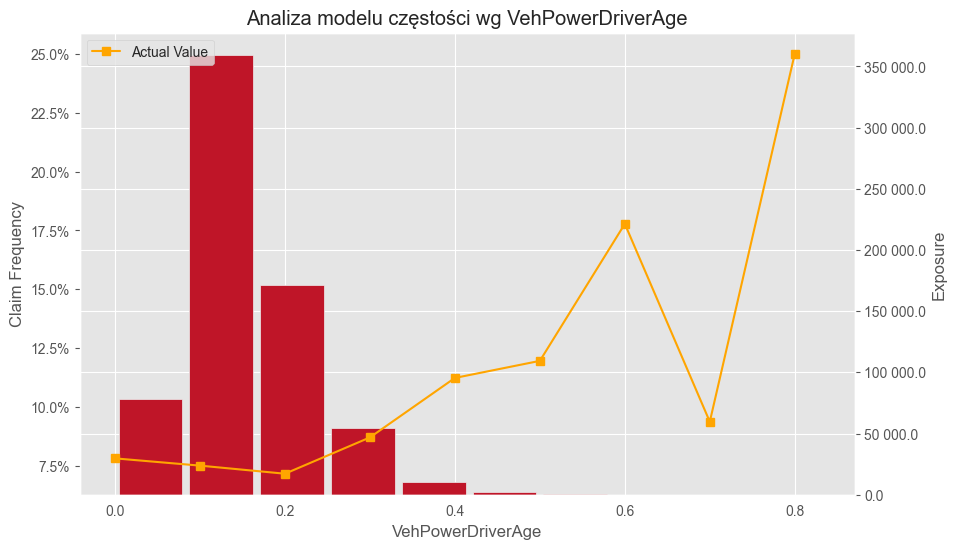

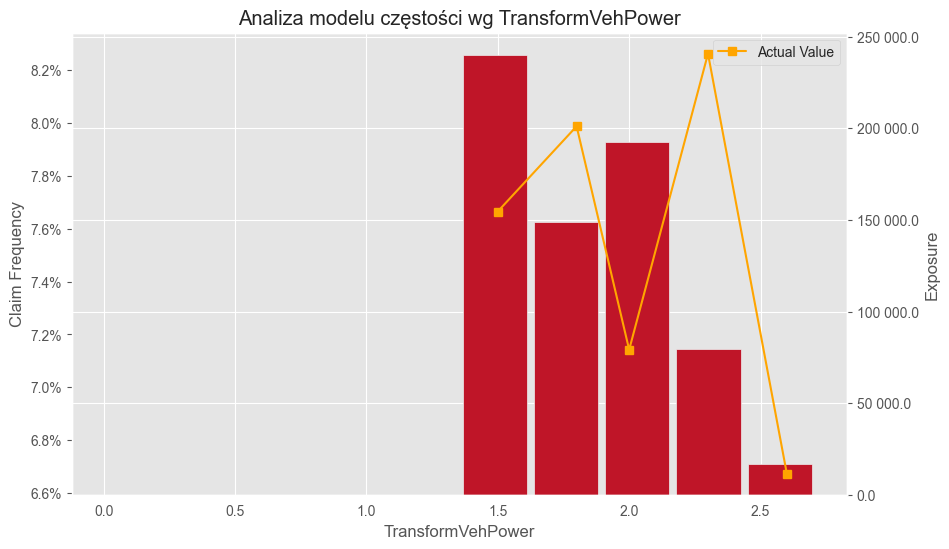

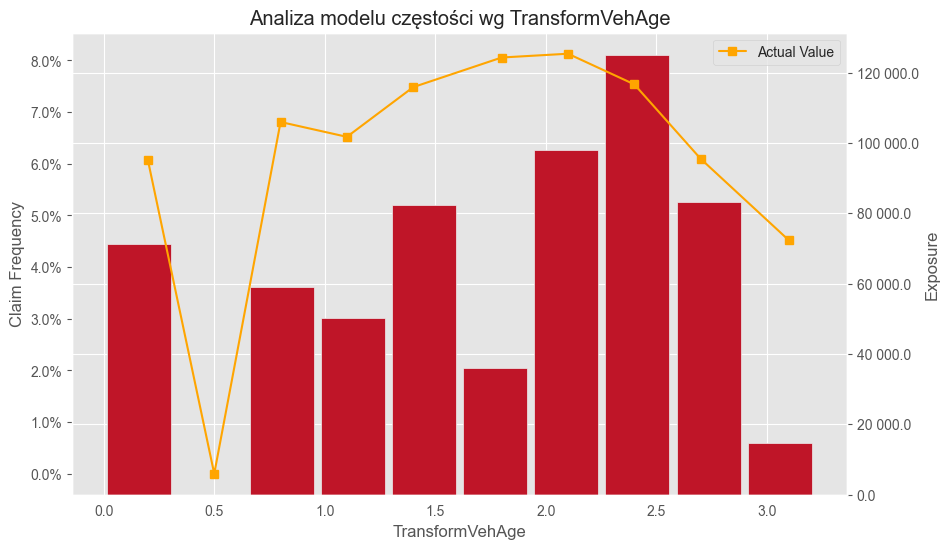

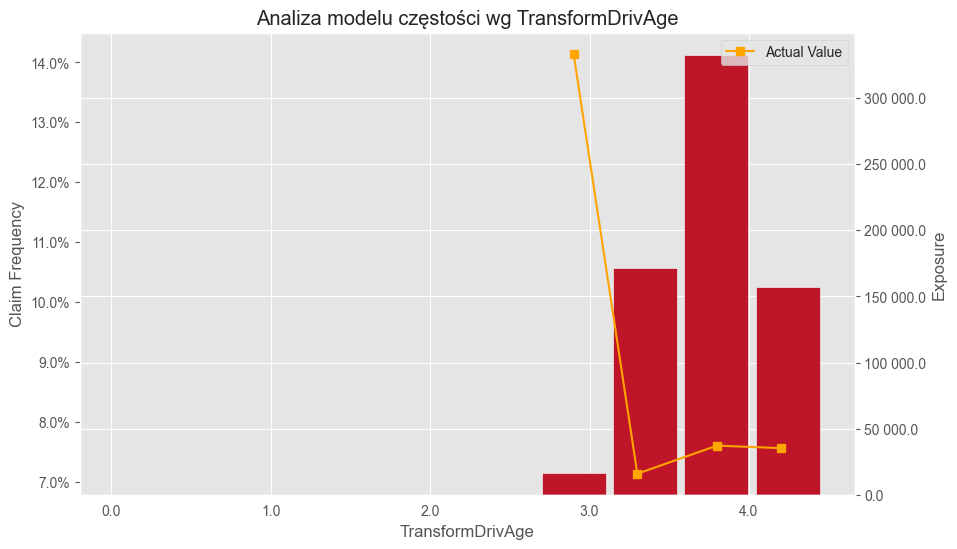

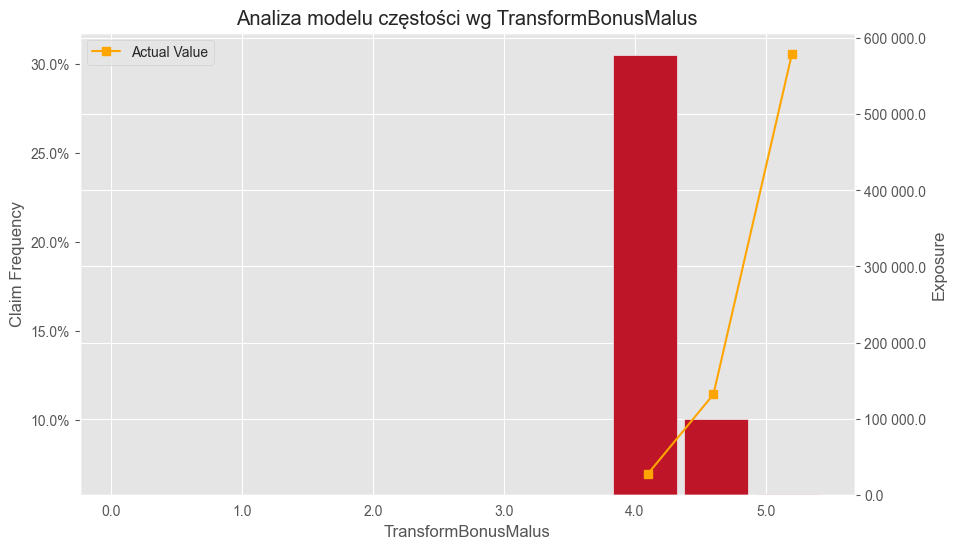

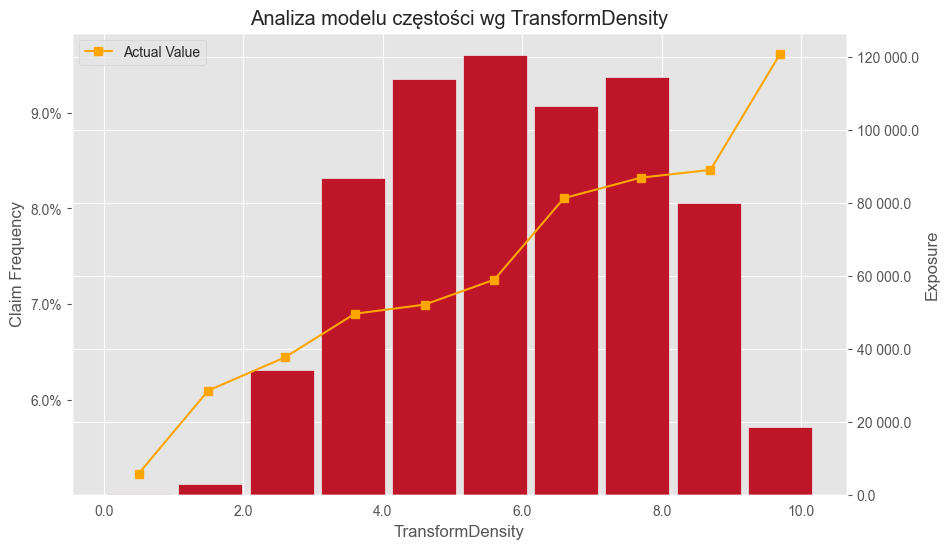

In [75]:
for col in ["VehPowerDriverAge", "TransformVehPower", "TransformVehAge", "TransformDrivAge", "TransformBonusMalus", "TransformDensity"]:
    model_analysis_plot(
        data=df_fe,
        x=col,
        y='ClaimFrequency',
        title=f'Analiza modelu częstości wg {col}'
    )

The newly created feature, vehicle power divided by driver age, still exhibits a weak linear correlation with claim frequency. However, among all available features, it remains one of the strongest predictors, making it valuable enough to retain as a variable. On the other hand, applying transformations to numerical features did not significantly improve the correlation or dispersion of claim frequency, except in the cases of Bonus/Malus and Density. Since the transformed versions of these two variables show better relationships with claim frequency, I will keep them and remove the original versions to prevent collinearity in the model.

<Axes: xlabel='VehAge', ylabel='Count'>

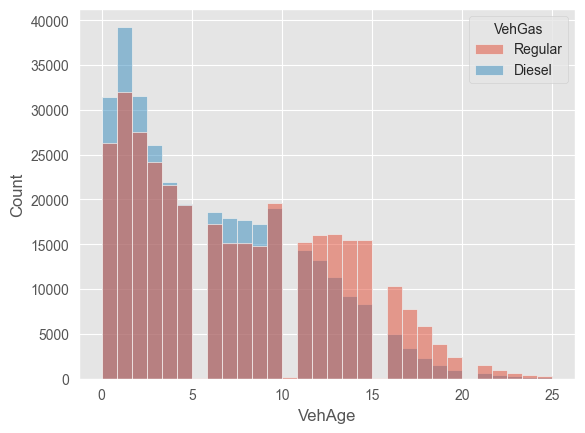

In [76]:
sns.histplot(data=df_freq, x="VehAge", hue="VehGas", bins=30, kde=False)

In [83]:
# creating additiona feature and deleting unnecessary
df_fe["isClaim"] = np.where(df_fe["ClaimNb"] > 0, 1, 0)
df_fe.drop(["BonusMalus", "Density", "TransformVehPower", "TransformDrivAge", "TransformVehAge", "ClaimNb", "Exposure"], axis=1, inplace=True)

In [84]:
# saving feature engineering results
df_fe.to_csv("feature_selected_data.csv", index=False)